In [1]:
import numpy as np
pixels = 10
size = 100
bases = np.random.uniform(-0.1,0.1,(pixels*pixels,size))

In [2]:
%load_ext cython

In [5]:
%%cython
import matplotlib.pyplot as plt
import scipy.io as sio
from scipy import ndimage
import numpy as np
from math import log

cdef int pixels = 10
cdef int size = 100
cdef int buffer = 5
cdef int num_batches = 10
cdef int num_trials = 10
cdef double eta = 1.0  #basis function learning rate



def get_random_image(images):
    cdef int image_number = np.random.randint(0, 10)
    return images[:,:,image_number]

def get_random_patch(image):
    cdef int x = np.random.randint(buffer, 512 - pixels - buffer)
    cdef int y = np.random.randint(buffer, 512 - pixels - buffer)
    return np.reshape(image[x:x+pixels,y:y+pixels], pixels*pixels)

cdef double S(x):
    return(log(1 + x*x))

cdef double Sprime(double x):
    if x >0:
        return(1.)
    else:
        return(-1.)
    #return(2*x/(1 + x*x))

def get_sparseness(weights, double sigma):
    cdef int i
    sparseness = 0
    for i in range(len(weights)):
        sparseness += S(weights[i]/sigma)
    return(-sparseness)

def get_preservation(image, weights, bases):
    cdef int x, i
    cdef double info
    info = 0
    for x in range(image.shape[0]):
        model = 0
        for i in range(bases.shape[1]):
            model += weights[i]*bases[x][i]
        info += (image[x] - model)**2
    return(-info)
    
def get_energy(weights, *args):
    patch, bases, sigma, lam = args
    sparseness = get_sparseness(weights,sigma)
    preservation = get_preservation(patch,weights,bases)
    return(-preservation-lam*sparseness)

def get_gradient(weights, *args):
    cdef double sigma, lam
    cdef double grad_i
    image, bases, sigma, lam = args
    grad = []
    cdef int i, j
    for i in range(len(weights)):
        grad_i = 0.0
        grad_i -= np.dot(bases[:,i], image)
        for j in range(len(weights)):
            grad_i += weights[j]*np.dot(bases[:,i], bases[:,j])
        grad_i += lam*Sprime(weights[i]/sigma)/sigma      
        grad.append(grad_i)
        
    return(np.array(grad))

def gradient_descent(image, bases, double sigma, double lam):
    cdef double gamma = 1e-3
    weights = np.zeros(size)
    cdef int i,j
    #Pick starting point for vector of weights
    for i in range(size):
        weights[i] = np.dot(bases[:,i], image)
    
    for j in range(10):
        weights += -gamma * get_gradient(weights, image, bases, sigma, lam)

    return(weights)

def plot_bases(bases):
    fig, axes = plt.subplots(nrows=5, ncols=5, sharex=True, sharey=True)
    axes = axes.ravel()
    for i in range(25):      
        axes[i].imshow(np.reshape(bases[:,i], (pixels, pixels)), cmap = 'plasma')
        axes[i].axis('off')
    plt.show()

def update_bases(bases,averages):
    cdef int i, x
    for i in range(bases.shape[1]):
        for x in range(bases.shape[0]):
            bases[x][i] += eta*averages[x][i]/float(num_trials)
    return(bases)

def sparse_net(bases):
    cdef int batch, trial, k, x, n
    cdef variance, sigma, lam
    contents = sio.loadmat('IMAGES.mat')
    for batch in range(num_batches): 
        plot_bases(bases)
        averages = np.zeros((pixels*pixels,size))
        image = get_random_image(contents['IMAGES'])
        variance = ndimage.variance(image)
        sigma = np.sqrt(variance)
        lam = 0.1*sigma
        for trial in range(num_trials):
            patch = get_random_patch(image)
            if ndimage.variance(patch) > 0.1*variance:
                weights = gradient_descent(patch, bases, sigma, lam)
                for k in range(averages.shape[1]):
                    for x in range(averages.shape[0]):
                        reconstruction = 0
                        for n in range(len(weights)):
                            reconstruction += weights[n]*bases[x][n]
                        averages[x][k] += weights[k]*(patch[x] - reconstruction)
        
        #Update basis functions
        bases = update_bases(bases, averages)
        
        #Normalize basis functions, to keep them from growing without bound
        bases = np.dot(bases, np.diag(1/np.sqrt(np.sum(bases**2, axis = 0))))


    return bases
        
    

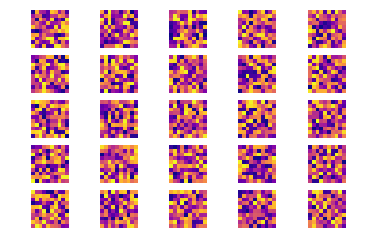

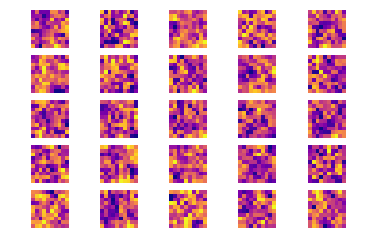

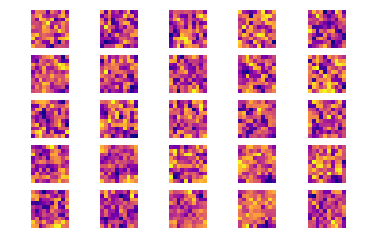

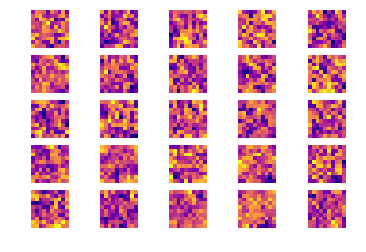

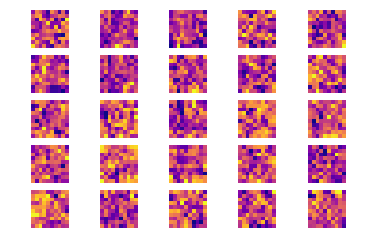

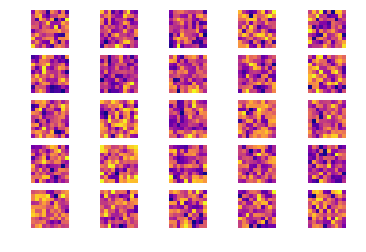

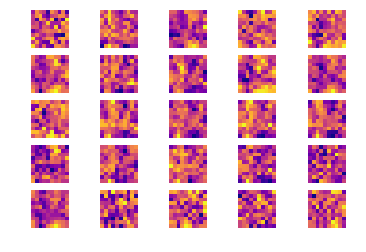

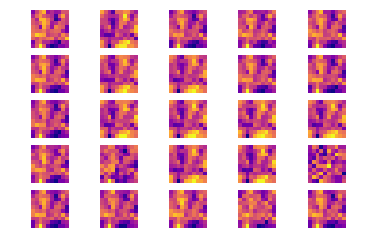

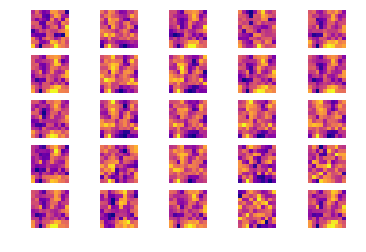

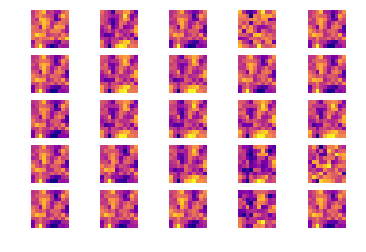

In [6]:
bases = sparse_net(bases)

In [ ]:
fig, axes = plt.subplots(nrows=10, ncols=10, sharex=True, sharey=True)
axes = axes.ravel()
for i in range(100):
    axes[i].imshow(np.reshape(bases[:,i], (pixels, pixels)), cmap = 'gray')
    axes[i].axis('off')
plt.show()

In [ ]:
from scipy import ndimage
from scipy import optimize
from math import log

def S(x):
    return(log(1 + x*x))

def Sprime(x):
    return(2*x/(1 + x*x))

def get_sparseness(weights,sigma):
    sparseness = 0
    for i in range(len(weights)):
        sparseness += S(weights[i]/sigma)
    return(-sparseness)

def get_preservation(image, weights, bases):
    info = 0
    for x in range(image.shape[0]):
        model = 0
        for i in range(bases.shape[1]):
            model += weights[i]*bases[x][i]
        info += (image[x] - model)**2
    return(-info)
    
def get_energy(weights, *args):
    patch, bases, sigma, lam = args
    sparseness = get_sparseness(weights,sigma)
    preservation = get_preservation(patch,weights,bases)
    return(-preservation-lam*sparseness)

def matrix_product(A,B):
    product = 0
    for x in range(A.shape[0]):
        for y in range(A.shape[0]):
            product += A[x][y]*B[x][y]
    return(product)
            

def get_gradient(weights, *args):
    image, bases, sigma, lam = args
    grad = []
    for i in range(len(weights)):
        grad_i = 0
        grad_i -= 2*np.dot(bases[:,i], image)
        for j in range(len(weights)):
            grad_i += weights[j]*np.dot(bases[:,i], bases[:,j])
        grad_i += lam*Sprime(weights[i]/sigma)/sigma
        
        grad.append(grad_i)
    return(np.array(grad))

def minimize_energy(patch, weights, bases, sigma, lam):
    args = (patch, bases, sigma, lam)
    x0 = np.zeros(size)
    res1 = optimize.fmin_cg(get_energy, x0, fprime=get_gradient,args=args,epsilon = 1, gtol = 0.1, maxiter = 5)
    return(res1)


    
def update_bases(bases,averages,eta):
    for i in range(bases.shape[1]):
        for x in range(bases.shape[0]):
            bases[x][i] += eta*averages[x][i]
    bases = np.dot(bases, np.diag(1/np.sqrt(np.sum(bases**2, axis = 0))))
    return(bases)
    